#  ARMA Prediction with a Kalman filter

In [1]:
import ssm

In [2]:
import jax
import einops
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [3]:
jax.devices()

[CpuDevice(id=0)]

In [4]:
%config InlineBackend.figure_format = "retina"

sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
# plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.rcParams["figure.figsize"] = (7.2, 3.0)

jnp.set_printoptions(linewidth=200)

In [5]:
plt.rcParams["text.usetex"] = True

In [6]:
%load_ext autoreload
%autoreload 2

## The Kalman filter and predictions

In [63]:
def forecast_obs_mean(F, H, mu, k):
    """
    Following Proposition 2.2 in F.02
    and pre-multiplying H
    """
    def _step(mu, _):
        mu_next = F @ mu
        return mu_next, H @ mu_next
    steps = jnp.arange(k)
    _, y_pred = jax.lax.scan(_step, mu, steps)
    y_init = H @ mu
    y_pred = jnp.concat([y_init[:, None], y_pred])
    return y_pred


def forecast_cov(F, Sigma, Q, R, H, k):
    """
    Following Proposition 2.3 in F.02
    """
    def _step(state, _):
        Sigma_mult, dynamics_carry, F_mult = state

        dynamics_carry = dynamics_carry + F_mult @ Q @ F_mult.T
        F_mult = F @ F_mult        
        Sigma_mult = F @ Sigma_mult @ F.T

        # EVC
        Sigma_pred = Sigma_mult + dynamics_carry
        # Predicted error
        var_pred = H @ Sigma_pred @ H.T + R
        
        state_next = (Sigma_mult, dynamics_carry, F_mult)
        return state_next, var_pred
    steps = jnp.arange(k)
    dim_state = len(Q)
    state_init = (Sigma, jnp.zeros((dim_state, dim_state)), F)
    _, var_pred = jax.lax.scan(_step, state_init, steps)
    return var_pred

In [64]:
def kf_step(bel, y, H, F, R, Q, n_forecast):
    mu, Sigma = bel

    # Predict
    mu_pred = F @ mu
    Sigma_pred = F @ Sigma @ F.T + Q

    # innovation
    S = H @ Sigma_pred @ H.T + R
    K = jnp.linalg.solve(S, H @ Sigma_pred).T
    err =  y - H @ mu_pred # innovation

    # Update
    mu_update = mu_pred + K @ err
    Sigma_update = Sigma_pred - K @ S @ K.T
    bel_next = (mu_update, Sigma_update)

    out = {
        "mu": mu_update,
        "Sigma": Sigma_update,
        "err": err,
        "yhat": H @ mu_pred,
        "y_filter": H @ mu_update,
        "y_forecast": forecast_obs_mean(F, H, mu_update, n_forecast),
    }

    return bel_next, out

## Defining the ARMA process

In [65]:
key = jax.random.PRNGKey(42)

In [66]:
ma_n = 10
R = jnp.eye(1) * 1.0 ** 2
H_ma = jnp.ones(10) * 1.
H, F, T = ssm.init_ma_components(H_ma=H_ma)

In [67]:
n_steps = 80
n_test = 20
steps = jnp.arange(n_steps)
sample = ssm.sample_ssm(key, F, H, T, R, n_steps + n_test)

test = jax.tree.map(lambda x: x[-n_test:], sample)
sample = jax.tree.map(lambda x: x[:-n_test], sample)

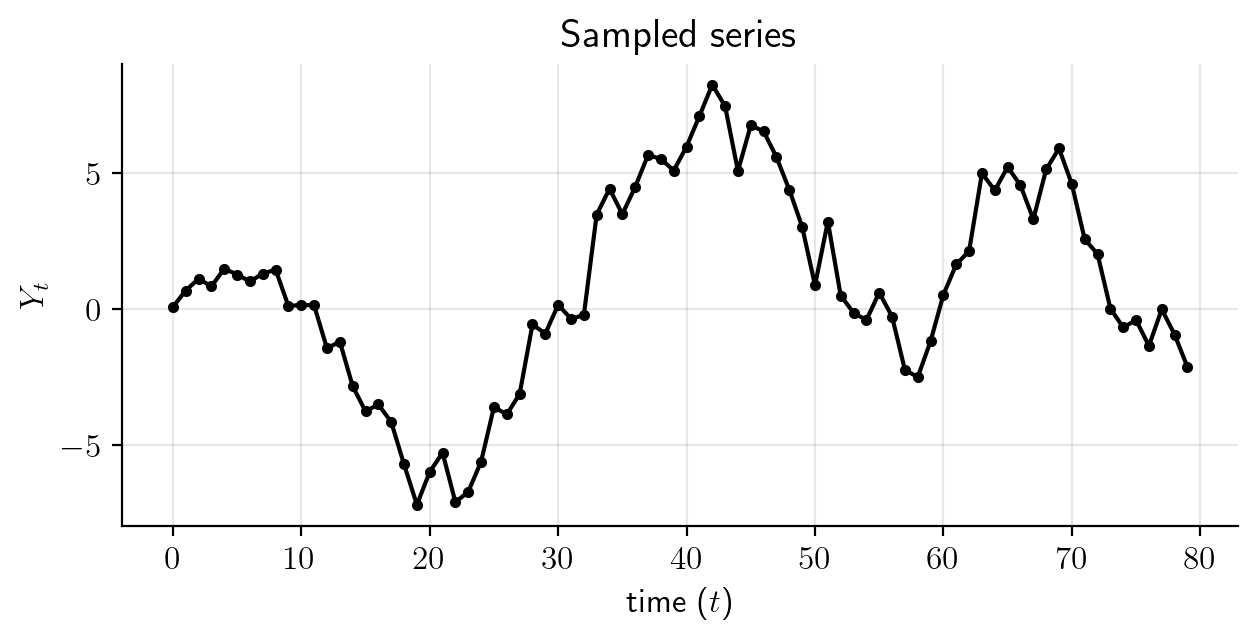

In [68]:
plt.plot(sample["y"], c="black", marker="o", markersize=3)
plt.xlabel("time ($t$)")
plt.title("Sampled series")
plt.ylabel("$Y_t$")
plt.grid(alpha=0.3)
plt.savefig("sample-ma-m.png", dpi=300, bbox_inches="tight")

In [69]:
n_forecast = 10
y = sample["y"]

mu_init = jnp.zeros(ma_n)
Sigma_init = jnp.eye(ma_n)
bel_init = (mu_init, Sigma_init)

Q = T @ R @ T.T
_step = partial(kf_step, H=H[None, :], F=F, R=R, Q=Q, n_forecast=n_forecast)
(mu, Sigma), hist = jax.lax.scan(_step, bel_init, y[:, None])

In [70]:
filter_hist = jnp.einsum("i,ti->t", H, hist["mu"])

In [71]:
jnp.sqrt(jnp.power(hist["err"], 2).mean())

Array(1.2539741, dtype=float32)

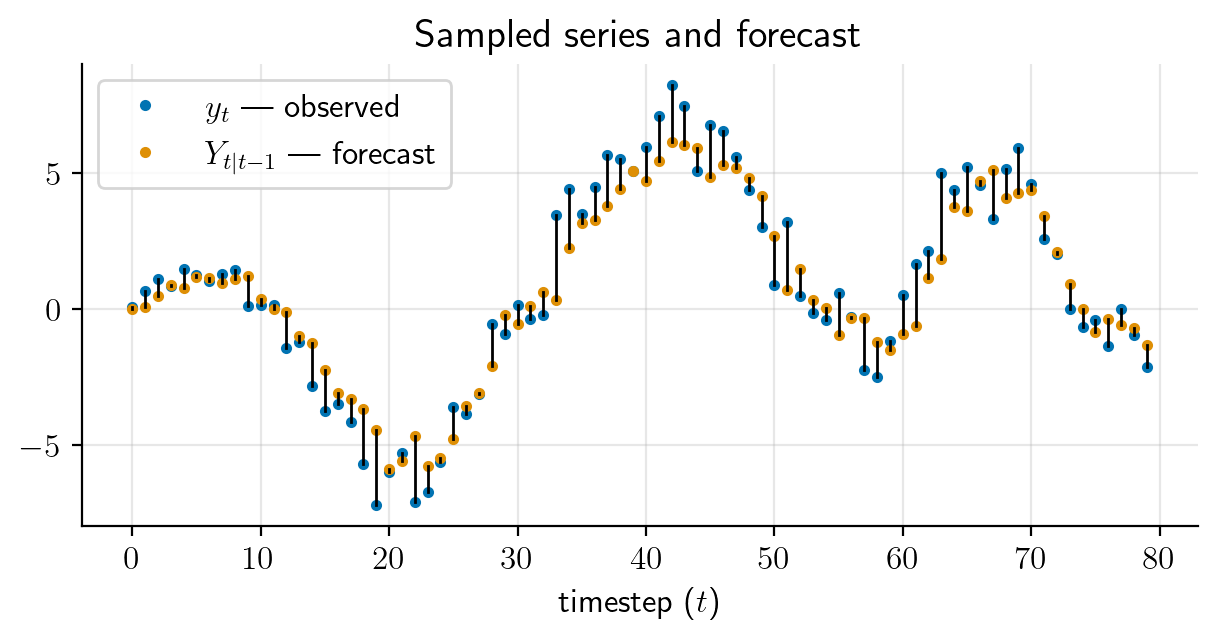

In [72]:
plt.plot(sample["y"], marker="o", markersize=3, label="$y_t$ — observed", linewidth=0)
plt.plot(hist["yhat"], marker="o", markersize=3, label="$Y_{t|t-1}$ — forecast", linewidth=0)

for t, (y, yhat) in enumerate(zip(sample["y"], hist["yhat"])):
    plt.plot([t, t], [y.item(), yhat.item()], c="black", linewidth=1)

plt.title("Sampled series and forecast")
plt.legend()
plt.xlabel("timestep ($t$)")
plt.grid(alpha=0.3)
plt.savefig("ma-m-sample-ohe-forecast.png", dpi=300, bbox_inches="tight")

### Multi-step-ahead

In [73]:
pred_ahead = hist["y_forecast"]
steps_ahead = jnp.arange(n_steps)[:, None] + jnp.arange(n_forecast + 1)[None, :]

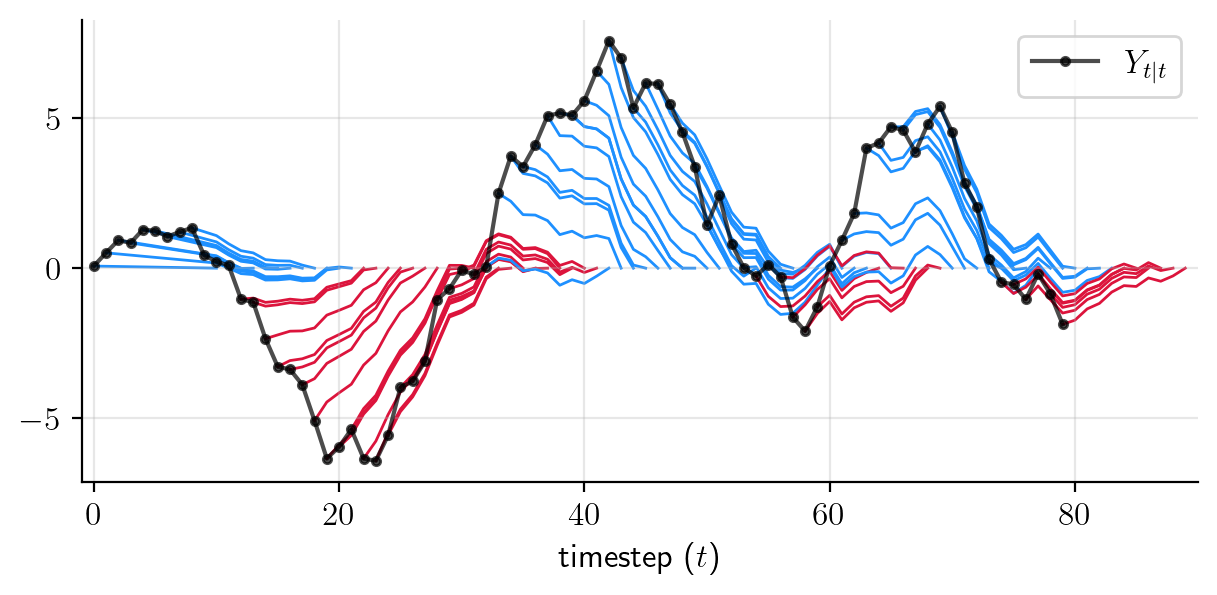

In [74]:
colors = plt.cm.viridis(jnp.linspace(0, 1, n_steps))
plt.plot(hist["y_filter"], marker="o", markersize=3, label="$Y_{t|t}$", c="black", alpha=0.7)
colors = plt.cm.viridis(jnp.linspace(0, 1, n_steps))
for color, k_steps, k_pred in zip(colors, steps_ahead, pred_ahead):
    # plt.plot(k_steps, k_pred, c="gray", alpha=0.5)
    color = "crimson" if k_pred[0] < 0 else "dodgerblue"
    plt.plot(k_steps, k_pred, c=color, alpha=1.0, zorder=0, linewidth=1)
plt.xlim(-1, 90)
plt.legend()
plt.xlabel("timestep ($t$)")
plt.grid(alpha=0.3)
plt.savefig("ma-m-multi-step-forecast.png", dpi=300, bbox_inches="tight")

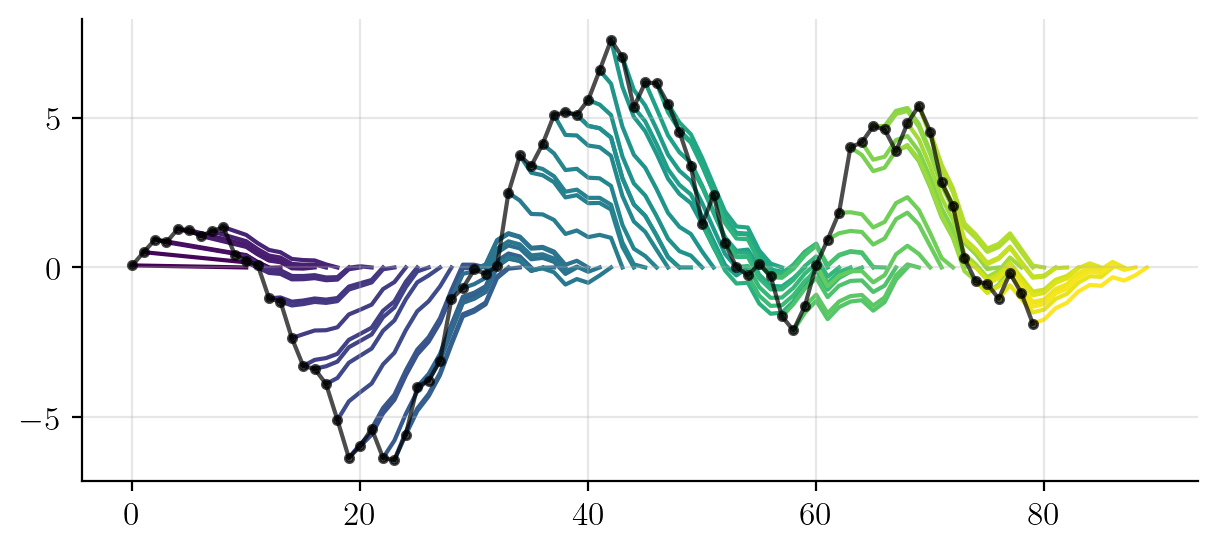

In [75]:
colors = plt.cm.viridis(jnp.linspace(0, 1, n_steps))
plt.plot(hist["y_filter"], marker="o", markersize=3, label="one-step-ahead forecast", c="black", alpha=0.7)
colors = plt.cm.viridis(jnp.linspace(0, 1, n_steps))
for color, k_steps, k_pred in zip(colors, steps_ahead, pred_ahead):
    # plt.plot(k_steps, k_pred, c="gray", alpha=0.5)
    # plt.scatter(k_steps[0], k_pred[0], facecolor=color, s=20, edgecolor="black")
    plt.plot(k_steps, k_pred, c=color, alpha=1.0, zorder=0)
# plt.xlim(0, 60)
plt.grid(alpha=0.3)

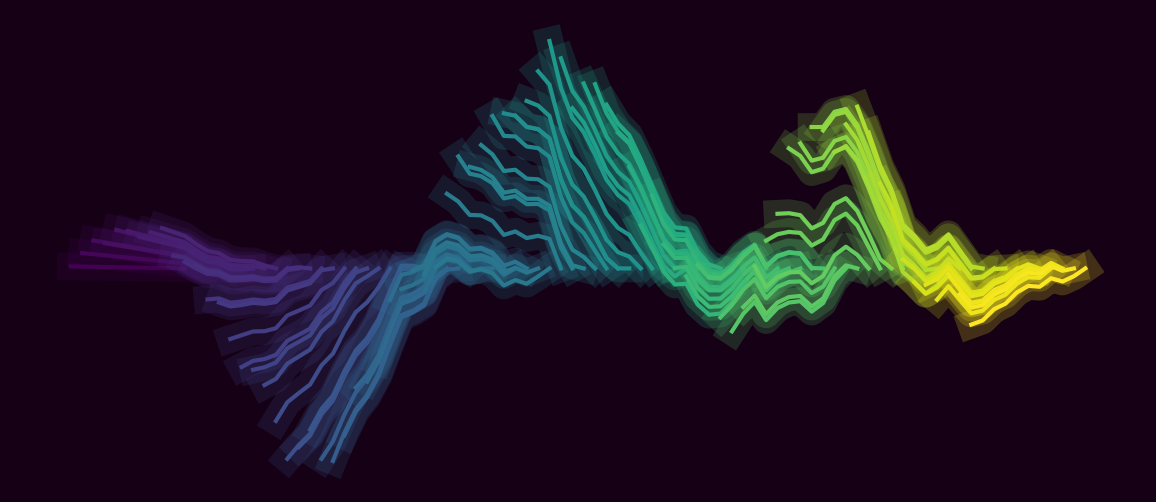

In [76]:
fig, ax = plt.subplots(facecolor="#150015")
colors = plt.cm.viridis(jnp.linspace(0, 1, n_steps))
for color, k_steps, k_pred in zip(colors, steps_ahead, pred_ahead):
    # plt.plot(k_steps, k_pred, c="gray", alpha=0.5)
    plt.plot(k_steps, k_pred, c=color, alpha=1.0, zorder=0)
    plt.plot(k_steps, k_pred, c=color, zorder=0, linewidth=10, alpha=0.2)
plt.grid(alpha=0.3)
plt.axis("off");
# plt.savefig("./arma-forecast.png", dpi=300, bbox_inches="tight")

## Predictions

In [77]:
mu = hist["mu"][-1]
Sigma = hist["Sigma"][-1]

steps_pred = jnp.arange(n_test) + n_steps

In [78]:
y_pred = forecast_obs_mean(F, H[None, :], mu, n_test)[1:].squeeze()
# y_pred = jnp.einsum("d,td->t", H, mu_pred)

In [82]:
var_pred = forecast_cov(F, Sigma, Q, R, H[None, :], n_test)
std_pred = jnp.sqrt(var_pred).squeeze()

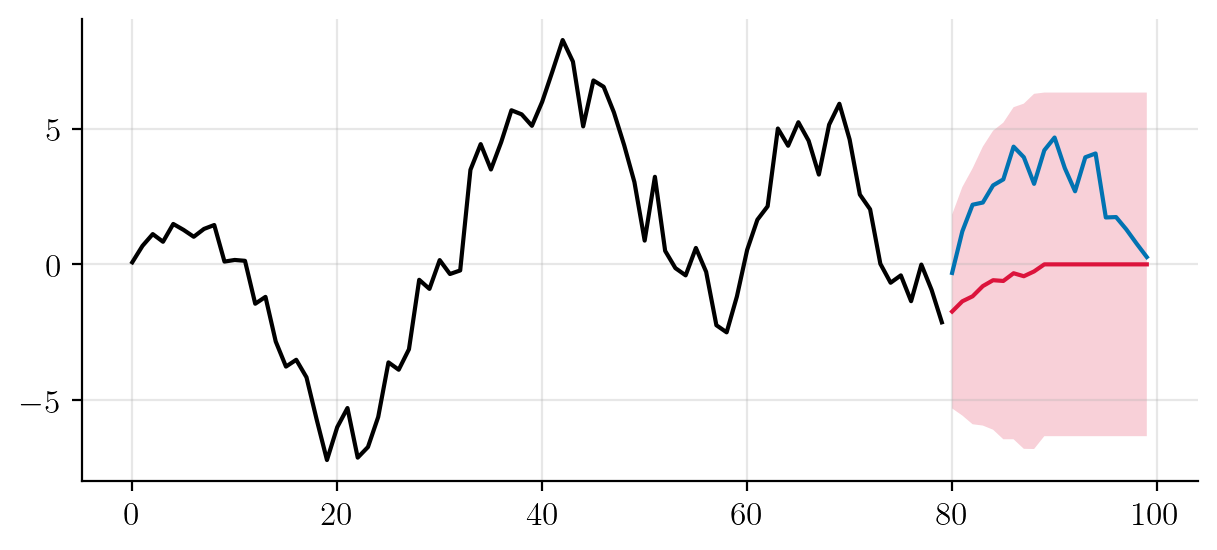

In [84]:
plt.plot(steps, sample["y"], c="black")
plt.plot(steps_pred, y_pred, c="crimson")
plt.plot(steps_pred, test["y"])
plt.fill_between(
    steps_pred, y_pred - 2*  std_pred, y_pred + 2 * std_pred,
    edgecolor="none",  facecolor="crimson", alpha=0.2
)
plt.grid(alpha=0.3)
plt.savefig("ma-m-forecast-and-error.png", dpi=300, bbox_inches="tight")

# Multiple forecasts

In [25]:
key = jax.random.PRNGKey(3141)

In [26]:
ma_n = 10
R = jnp.eye(1) * 1.0 ** 2
H_ma = jnp.ones(10) * 1.
H, F, T = ssm.init_ma_components(H_ma=H_ma)

In [27]:
n_steps = 150
n_test = 20
steps = jnp.arange(n_steps)
sample = ssm.sample_ssm(key, F, H, T, R, n_steps + n_test)

test = jax.tree.map(lambda x: x[-n_test:], sample)
sample = jax.tree.map(lambda x: x[:-n_test], sample)

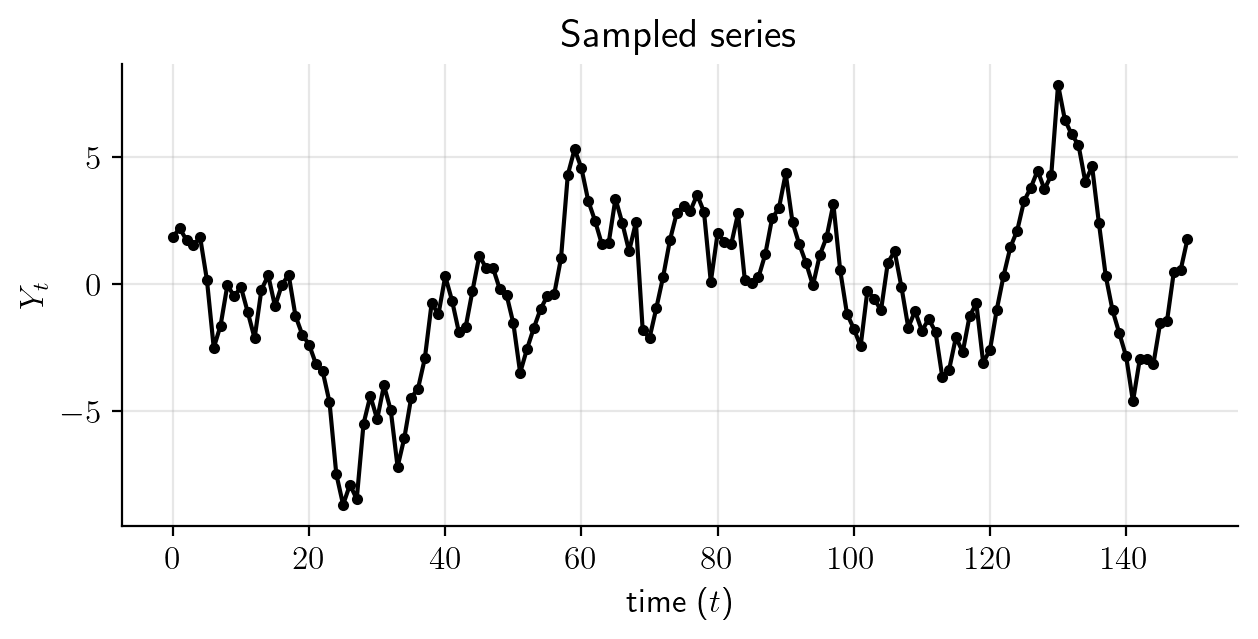

In [28]:
plt.plot(sample["y"], c="black", marker="o", markersize=3)
plt.xlabel("time ($t$)")
plt.title("Sampled series")
plt.ylabel("$Y_t$")
plt.grid(alpha=0.3)

## Animation

In [29]:
from matplotlib.animation import FuncAnimation

In [30]:
n_forecast = 10
y = sample["y"]

mu_init = jnp.zeros(ma_n)
Sigma_init = jnp.eye(ma_n)
bel_init = (mu_init, Sigma_init)

Q = T @ R @ T.T
_step = partial(kf_step, H=H[None, :], F=F, R=R, Q=Q, n_forecast=n_forecast)
(mu, Sigma), hist = jax.lax.scan(_step, bel_init, y[:, None])

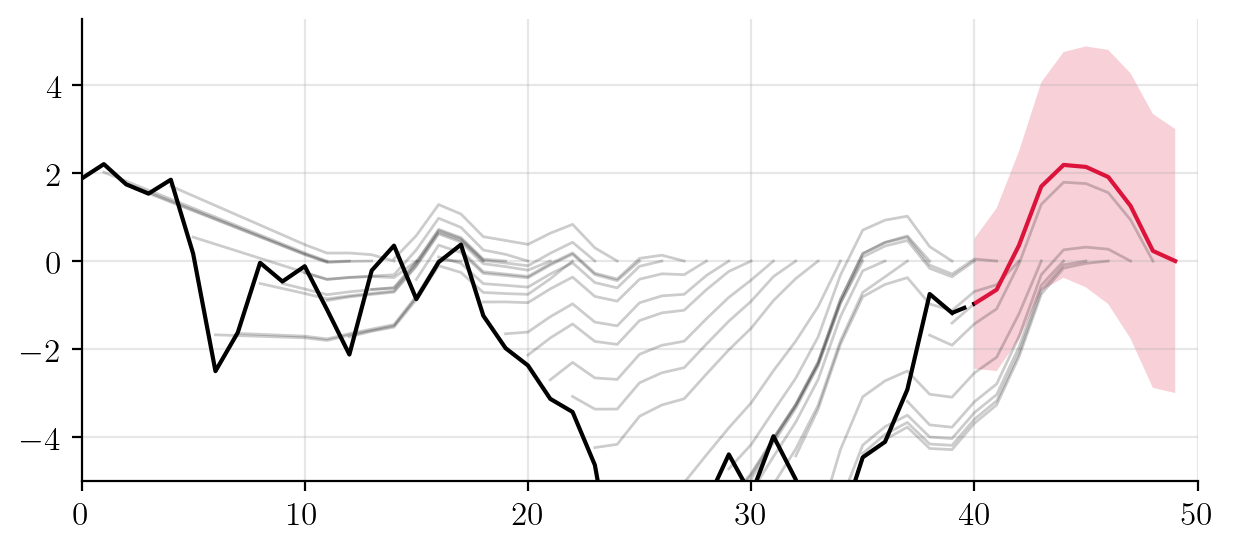

In [31]:
fig, ax = plt.subplots()

n_test = 10
def anim(step):
    ax.cla()
    steps_pred = jnp.arange(n_test) + step
    
    mu = hist["mu"][step-1]
    Sigma = hist["Sigma"][step-1]
    
    y_pred = forecast_obs_mean(F, H[None, :], mu, n_test)[1:].squeeze()
    Sigma_pred = forecast_cov(F, Sigma, Q, n_test)
    std_pred = jnp.sqrt(jnp.einsum("sij,i,j->s", Sigma_pred, H, H))

    for tau in range(1, step):
        steps_sub = jnp.arange(n_test + 1) + tau
        plt.plot(steps_sub, hist["y_forecast"][tau].squeeze(), c="black", linewidth=1, alpha=0.2)
    
    plt.plot(steps[:step], sample["y"][:step], c="black")
    plt.plot(steps_pred, y_pred, c="crimson")
    plt.plot(steps[step-1:step+1], [sample["y"][step-1], y_pred[0]], c="black", linestyle="--")
    
    plt.fill_between(
        steps_pred, y_pred -  std_pred, y_pred + std_pred,
        edgecolor="none",  facecolor="crimson", alpha=0.2
    )
    plt.xlim(jnp.maximum(0, step - 40), step + n_test)
    plt.ylim(-5, 5.5)
    plt.grid(alpha=0.3)

# anim(50)
    
animate = FuncAnimation(fig, anim, jnp.arange(40, n_steps))
animate.save("forecasts.mp4", fps=7)

## Refernces

1. https://proceedings.mlr.press/v30/Anava13.html